### POS log analysis to identify growth opportunities with a subset of clients 

In [1]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import OrdinalEncoder

import datetime
from datetime import date
import calendar

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7, 8.27

In [3]:
# loading the dataset
df = pd.read_csv("/Users/raviswanath/Desktop/python notebooks/Toast Case Study.csv")

### Pre-Processing and Exploratory Analysis

In [6]:
# changing the column names to make the analysis much more convenient 
df.columns = ['RestaurantId', 'OrderPaymentId', 'PaymentType', 'PaymentStatus',
              'DateofPayment', 'PaiddateTimestamp', 'OrderAmount',
              'TipAmount', 'ServerId', 'DigitalReceipt', 'RefundStatus',
              'Deleted']

# The paid timestamp column is of the type int; need to convert it to a datetime format
df['DateofPayment'] = pd.to_datetime(df['DateofPayment'].astype(str), format='%Y%m%d')

# converting the IDs into categories
df.RestaurantId = df.RestaurantId.astype('str')
df.OrderPaymentId = df.OrderPaymentId.astype('category')
df.ServerId = df.ServerId.astype('category')

# Encoding the restaurant ID with simple IDs to make visualization and analysis easier
encoder_dict = {'1232000000000000':1, '2991000000000000':3, '1233000000000000':2, 
                        '2998000000000000':4, '3619000000000000':5}
df['RestaurantId_encoded'] = df['RestaurantId'].map(encoder_dict)

Index(['RestaurantId', 'OrderPaymentId', 'PaymentType', 'PaymentStatus',
       'DateofPayment', 'PaiddateTimestamp', 'OrderAmount', 'TipAmount',
       'ServerId', 'DigitalReceipt', 'RefundStatus', 'Deleted'],
      dtype='object')

In [11]:
df.describe()

,OrderAmount,TipAmount
count,225093.000000,225093.000000
mean,9.729241,0.441614
std,7.878836,0.936885
min,-118.450000,0.000000
25%,4.980000,0.000000
50%,7.490000,0.000000
75%,11.660000,0.500000
max,326.350000,30.170000


In [12]:
df.isnull().sum()/len(df)

RestaurantId         0.0
OrderPaymentId       0.0
PaymentType          0.0
PaymentStatus        0.0
DateofPayment        0.0
PaiddateTimestamp    0.0
OrderAmount          0.0
TipAmount            0.0
ServerId             0.0
DigitalReceipt       0.0
RefundStatus         0.0
Deleted              0.0
dtype: float64

Awesome, there is no missing data!
However, the min value of the order amount is -118.45. Need to find more about the value of such orders and confirm that they are prospective returns or rejected payments due to some reason. 

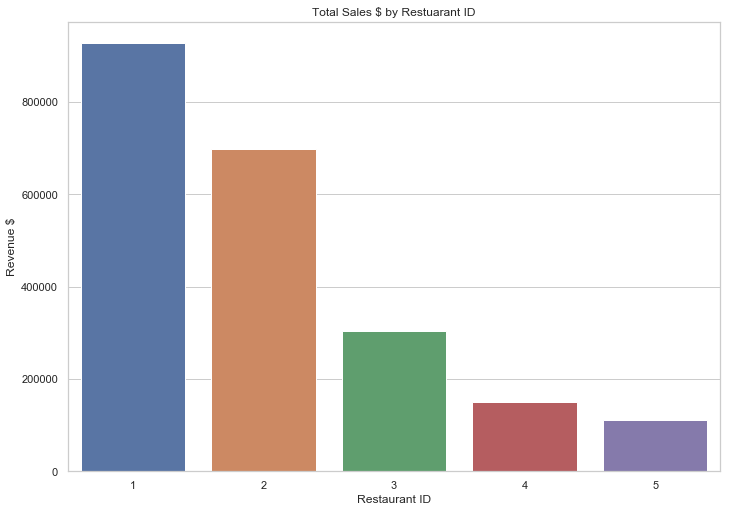

In [15]:
sns.barplot(x="RestaurantId_encoded", y="OrderAmount",
            data=df.groupby(['RestaurantId_encoded'])["OrderAmount"].sum().reset_index())

plt.title("Total Sales $ by Restuarant ID")
plt.xlabel('Restaurant ID')
plt.ylabel('Revenue $')
plt.show()

#### The negative order amount lines

In [17]:
df[df.OrderAmount < 0].shape

(175, 13)

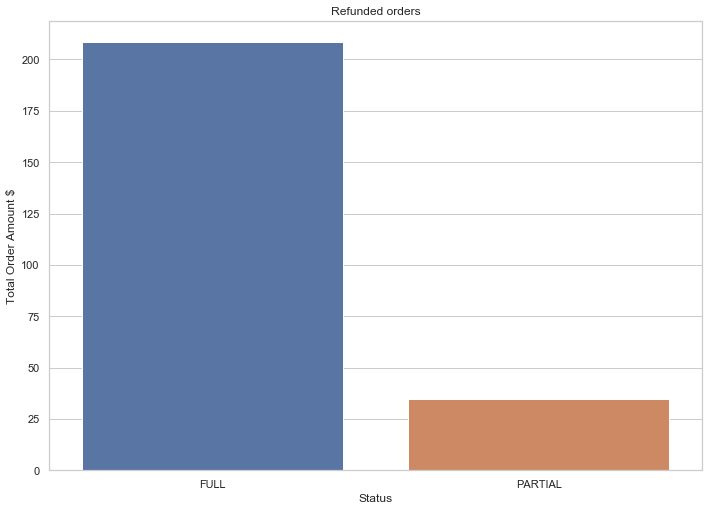

In [16]:
sns.barplot(x="RefundStatus", y="OrderAmount",
data=df[(df["RefundStatus"]=="FULL")|
          (df["RefundStatus"]=="PARTIAL")].groupby(["RefundStatus"])["OrderAmount"].sum().reset_index())

plt.title("Refunded orders")
plt.xlabel("Status")
plt.ylabel("Total Order Amount $")
plt.show()

The negative orders are not returns as counter proven by the above plot. Given their values are so less, we can filter them out or ignore their presence and continue the analysis without any significant misleading indications.

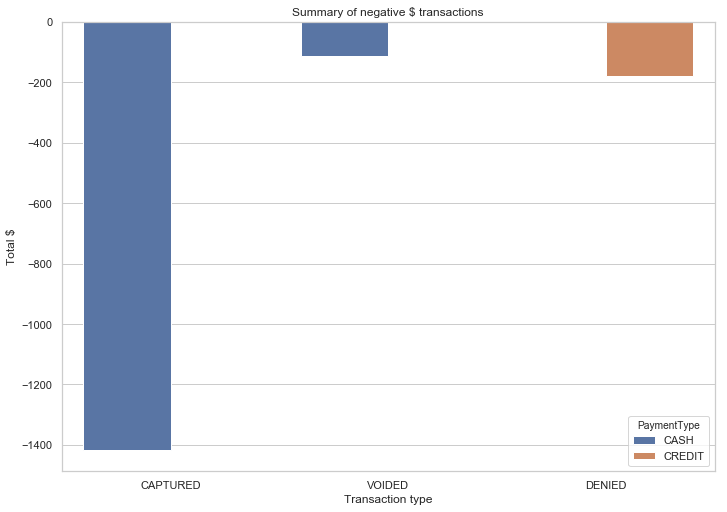

In [17]:
sns.barplot(x='PaymentStatus', y='OrderAmount', hue='PaymentType',
    data=df[df.OrderAmount < 0].groupby(["PaymentType", "PaymentStatus"])["OrderAmount"].sum().reset_index())

plt.title("Summary of negative $ transactions")
plt.xlabel("Transaction type")
plt.ylabel("Total $")
plt.show()

Maximum volume of the negative transactions have happened via Cash, which makes the assumption that these entries were created to settle the balance between a changed/mispaced order that were paid by card, valid. 

It is also clear that there is no Credit transaction that was captured. All Credit negative transactions were "Denied". 

#### Sales by day of week

In [18]:
# Take the date out into X
X = df["DateofPayment"]
# map it into the day of week in int using the weekday function
X = X.apply(date.weekday)
# convert the integer into Day of week names
Y = [calendar.day_name[i] for i in X]
# append back to the data frame
df["DayofWeek"] = pd.DataFrame(Y)

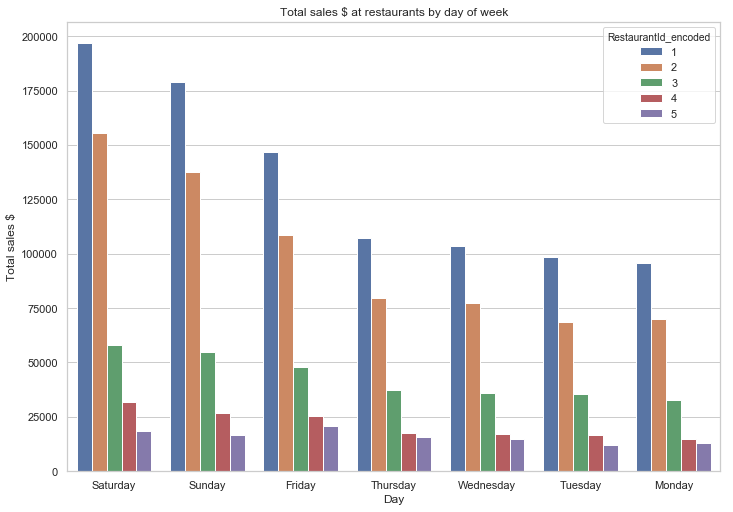

In [19]:
# Sales by Day of week for each restaurant Id
sns.barplot(x="DayofWeek", y="OrderAmount", hue="RestaurantId_encoded",
data=df.groupby(['RestaurantId_encoded',
                  'DayofWeek'])["OrderAmount"].sum().sort_values(ascending=False).reset_index())

plt.title("Total sales $ at restaurants by day of week")
plt.xlabel("Day")
plt.ylabel("Total sales $")
plt.show()

#### Analyzing the time of sales

In [21]:
#copying the datetime column into Y
Y = df["PaiddateTimestamp"]

#converting from string to Datetime object
Y = pd.to_datetime(Y, infer_datetime_format=True)

#rounding off to the relevant hour mark 
Y = Y.dt.round('H')

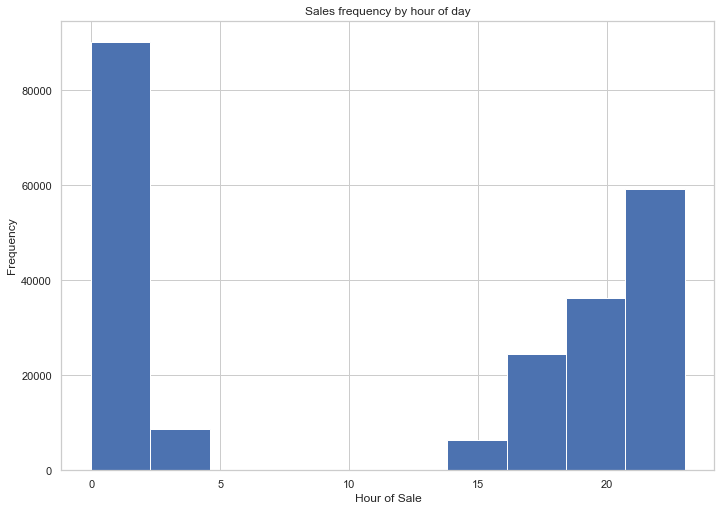

In [23]:
Hour = Y.dt.hour
Hour.hist()
plt.xlabel("Hour of Sale")
plt.ylabel("Frequency")
plt.title("Sales frequency by hour of day")
plt.show()

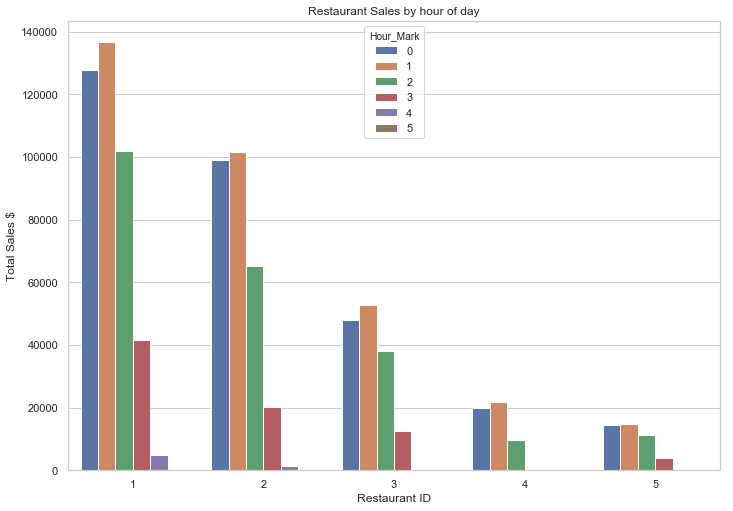

In [25]:
df["Hour_Mark"] = Hour
data = df.groupby(["RestaurantId_encoded", "Hour_Mark"])["OrderAmount"].sum().reset_index()
sns.barplot(x = "RestaurantId_encoded", y = "OrderAmount", hue = "Hour_Mark",
               data = data[data["Hour_Mark"]<=5])

plt.xlabel('Restaurant ID')
plt.ylabel('Total Sales $')
plt.title('Restaurant Sales by hour of day')
plt.show()

Evident from the plots that it reasonable to assume that all 5 restaurants are in a different time zone as to what the POS system machine has collected the data in. Subtracting 3 hours out of each time entry would be a reasonable assumption to make, given most people get back home by midnight even after say a late night dinner during the weekends. 

In [26]:
Y = Y - pd.Timedelta('3 hours')
Adjusted_hour = Y.dt.hour

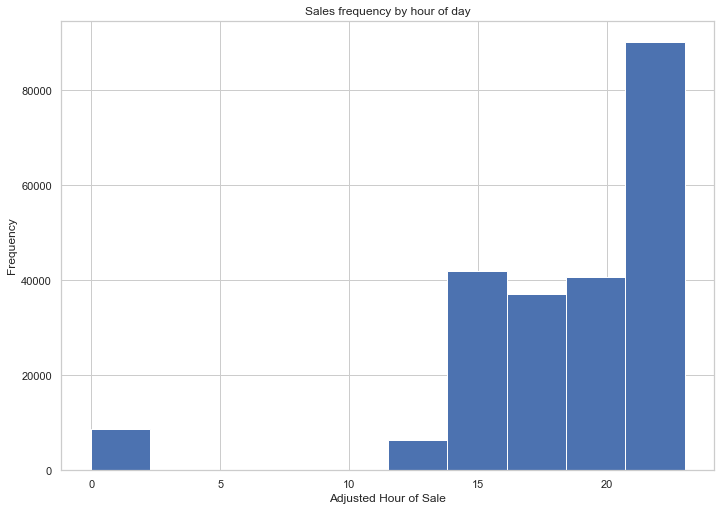

In [27]:
Adjusted_hour.hist()
plt.xlabel("Adjusted Hour of Sale")
plt.ylabel("Frequency")
plt.title("Sales frequency by hour of day")
plt.show()

In [28]:
#removing hour mark and replacing it with adjusted_hour
df.drop("Hour_Mark", axis = 1, inplace = True)
df["Hour"]= Adjusted_hour

# Since a few of the lines still seem to have happened well beyond midnight, it is reasonable to assume that those sales
# were rather part of the previous night than have them be counted for the next day.
df.iloc[:, 14][df.Hour==0] = 24

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [29]:
# re-storing data with the changed Hour mark column
data = df.groupby(["RestaurantId_encoded", "Hour"])["OrderAmount"].sum().reset_index()

In [30]:
data.shape

(72, 3)

In [31]:
# Function to create a meal label by hour of the day
def create_meal_lables(x):
    if(x<=14):
        return 'Lunch'
    elif((x>14) & (x<=16)):
        return 'Snack'
    elif((x>16) & (x<=19)):
        return 'Early Dinner'
    else:
        return 'Late Dinner'        

In [32]:
data["Type_of_Meal"] = data['Hour'].apply(create_meal_lables)

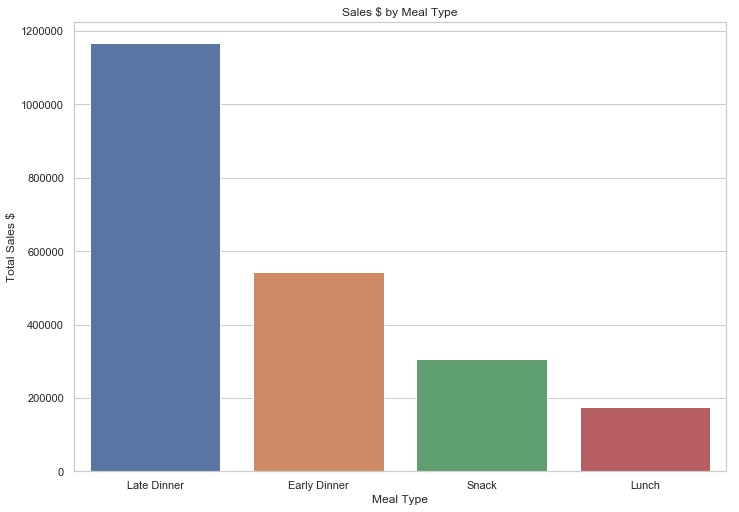

In [34]:
sns.barplot(x ="Type_of_Meal", y = "OrderAmount", 
            data = data.groupby(["Type_of_Meal"])["OrderAmount"].sum().sort_values(ascending = False).reset_index())
plt.xlabel('Meal Type')
plt.ylabel('Total Sales $')
plt.title("Sales $ by Meal Type")
plt.show()

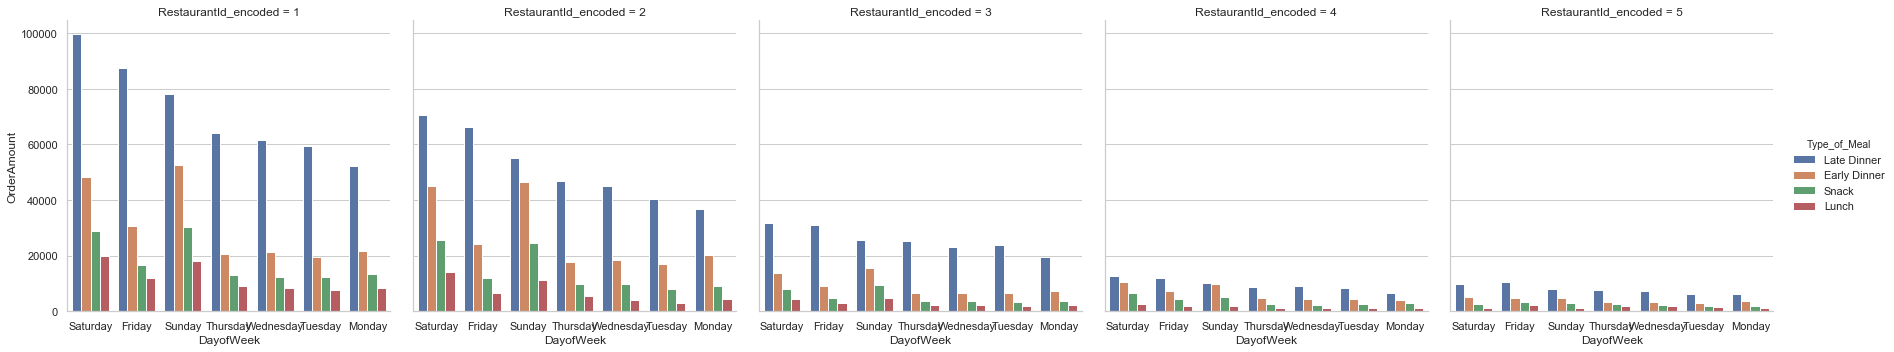

In [35]:
df["Type_of_Meal"] = df["Hour"].apply(create_meal_lables)
sns.catplot(x = "DayofWeek", y = "OrderAmount", hue = "Type_of_Meal", col = "RestaurantId_encoded", 
data = df.groupby(["RestaurantId_encoded", "DayofWeek", "Type_of_Meal"])["OrderAmount"].sum().sort_values(ascending = False).reset_index(),
        kind = 'bar')
plt.show()

* Late dinner revenue simply dominates across all the restarants, followed by early dinner, snack and lunch. This  indicates that this is a chain that probably only opens during mid day and serves unitl mid night. 

* Looking at the patterns, this looks like a bar/pub chain that serves snacks and few other items as well during the day, having stores 1 and 2 in a hot downtown location with the other three further out of the city limits. 

* It is also possible that the other reataurants are in the city but are relatively new and less popular among the city dwellers.

### Line chart of sales across time by restaurant ID/ pub ID

In [37]:
sns.set(style = "darkgrid")

In [36]:
df["Month"] = df["DateofPayment"].dt.month
df["Year"] = df["DateofPayment"].dt.year

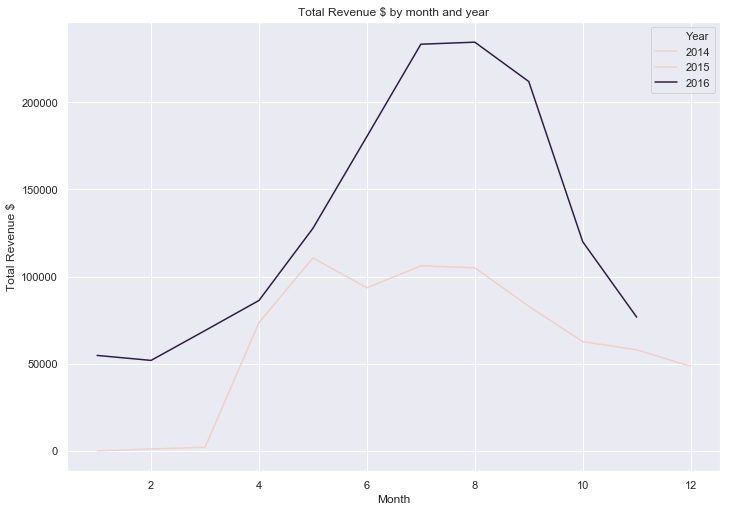

In [38]:
# Overall Sales by month and Year
sns.lineplot( y = "OrderAmount", x = "Month", hue = "Year",
    data = df[df["Year"] > 2014].groupby(["Month", "Year"])["OrderAmount"].sum().reset_index())
plt.title('Total Revenue $ by month and year')
plt.xlabel("Month")
plt.ylabel("Total Revenue $")
plt.show()

Revenue has grown 2x during the peak months of July to September between 2015 and 2016.

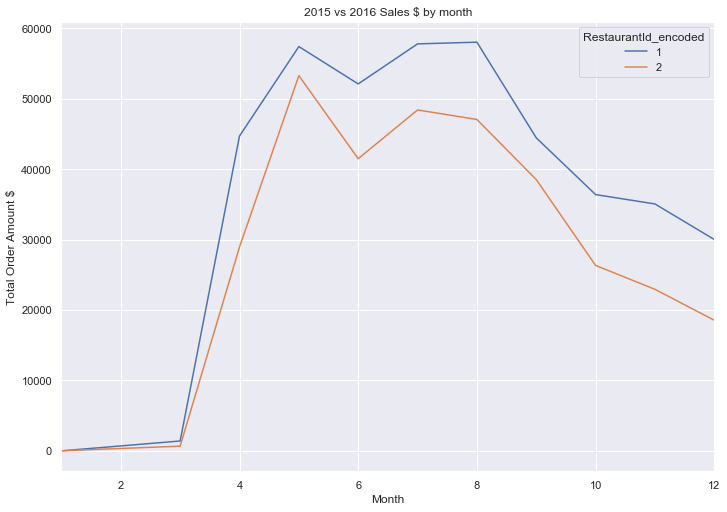

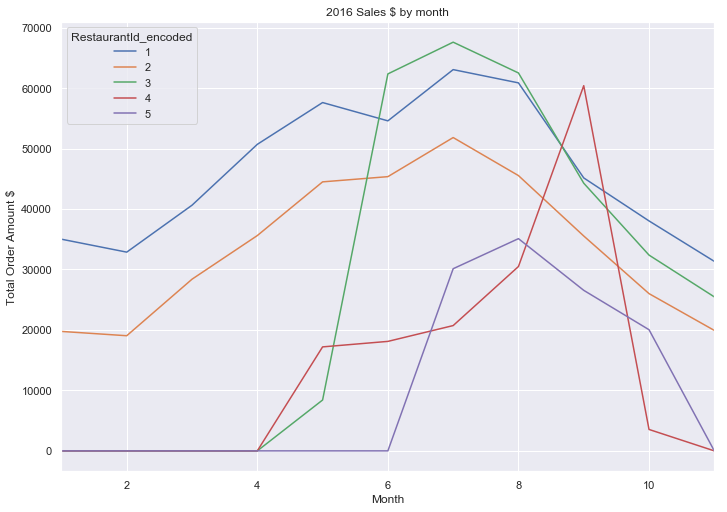

In [39]:
df[df.Year == 2015].groupby(["Month", "RestaurantId_encoded"])["OrderAmount"].sum().unstack().fillna(0).plot()
plt.title("2015 vs 2016 Sales $ by month")
plt.xlabel("Month")
plt.ylabel("Total Order Amount $")


df[df.Year == 2016].groupby(["Month","RestaurantId_encoded",])["OrderAmount"].sum().unstack().fillna(0).plot()
plt.title("2016 Sales $ by month")
plt.xlabel("Month")
plt.ylabel("Total Order Amount $")

plt.show()

* The above line charts forces us to re-think our assumptions about the locations of these pubs. Location ID's 3, 4 and 5 have only started in 2016, which is why the overall sales volume was evidently lower as compared to restaurants 1 and 2 in the overall charts. 


* Location 3 seems to be a super hit, surpassing sales from IDs 1 and 2 during the peak months, with restaurant 4 catching up a bit late with the sales. Maybe we see this effect because ID 4 is in a different location? Or maybe, due to some promotional campaign rolled out to boost sales in the newly opened stores? 

* What ever the reason may be, the data shows that from a revenue stand point, the chain is doing pretty good, making $1.45M in 2016.


* Restaurant ID's 1 and 2 have achieved the same levels of sales during the peak months. The brand is showing growth year on year when compared to 2015 by adding new stores. 


* It would be fair to assume that this growth story would continue and the chain would continue to operate at the same levels, year on year, becoming a valued customer.

---